![image](https://user-images.githubusercontent.com/20357655/145710301-ad00ab66-2378-404f-a918-576aba834ff9.png)

In this homework, we will try to implement a `View Synthesis` model that allows us to generate new scene views based on a single image.

The basic idea is to use `differentiable point cloud rendering`, which is used to convert a hidden 3D feature point cloud into a target view.
The projected features are decoded by `refinement network` to inpaint missing regions and generate a realistic output image.

### Overall pipeline disribed below

![image](https://user-images.githubusercontent.com/20357655/145710444-0d0e163f-6996-4eb8-81c0-69798b11c5a6.png)

# Data
## Download KITTI dataset

In [1]:
from gfile import download_file_from_google_drive


download_file_from_google_drive('1lqspXN10biBShBIVD0yvgnl1nIPPhRdC','kitti.zip')

In [2]:
!unzip kitti.zip

Streaming output truncated to the last 5000 lines.
 extracting: dataset_kitti/images/08_001864.png  
 extracting: dataset_kitti/images/08_001865.png  
 extracting: dataset_kitti/images/08_001866.png  
 extracting: dataset_kitti/images/08_001867.png  
 extracting: dataset_kitti/images/08_001868.png  
 extracting: dataset_kitti/images/08_001869.png  
 extracting: dataset_kitti/images/08_001870.png  
 extracting: dataset_kitti/images/08_001871.png  
 extracting: dataset_kitti/images/08_001872.png  
 extracting: dataset_kitti/images/08_001873.png  
 extracting: dataset_kitti/images/08_001874.png  
 extracting: dataset_kitti/images/08_001875.png  
 extracting: dataset_kitti/images/08_001876.png  
 extracting: dataset_kitti/images/08_001877.png  
 extracting: dataset_kitti/images/08_001878.png  
  inflating: dataset_kitti/images/08_001879.png  
 extracting: dataset_kitti/images/08_001880.png  
 extracting: dataset_kitti/images/08_001881.png  
 extracting: dataset_kitti/images/08_001882.png  

## Dataset

In [3]:
! pip install "git+https://github.com/facebookresearch/pytorch3d.git@stable"

  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-bd_dwt52
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-bd_dwt52
  Running command git checkout -q 3fc3ea507bfbf7e1c2d5023a6db202698206f91d
     |████████████████████████████████| 49 kB 4.3 MB/s 
     |████████████████████████████████| 596 kB 24.4 MB/s 
  Created wheel for pytorch3d: filename=pytorch3d-0.6.1-cp37-cp37m-linux_x86_64.whl size=30301392 sha256=b7b11d65c7168cc5cdec8baa5aa288efbf84bd9dc299ddabd08d3d9c57e13dbf
  Stored in directory: /tmp/pip-ephem-wheel-cache-a_s47e_f/wheels/4c/03/f0/326bb241eb86a155a12f217c81e163fbba48424bb84fa22074
  Created wheel for fvcore: filename=fvcore-0.1.5.post20211023-py3-none-any.whl size=60947 sha256=ad2676242278d4d42c058796d3354e280ded8e3b4e4ef431c3357cb6f6edde6a
  Stored in directory: /root/.cache/pip/wheels/16/98/fc/252d62cab6263c719120e06b28f3378af59b52ce7a20e81852
Successfully built pytor

In [1]:
%pylab inline

from tqdm import tqdm
from itertools import islice
from IPython.display import clear_output, HTML
from collections import defaultdict

from kitti import KITTIDataLoader

import torch
from torch import nn
from torch.utils.data import Subset, DataLoader

import torchvision

from pytorch3d.vis.plotly_vis import plot_scene
from pytorch3d.structures import Pointclouds
from pytorch3d.renderer import PerspectiveCameras, compositing, rasterize_points

Populating the interactive namespace from numpy and matplotlib


In [2]:
def split_RT(RT):
    return RT[..., :3, :3], RT[..., :3, 3]

def renormalize_image(image):
    return image * 0.5 + 0.5

In [3]:
dataset = KITTIDataLoader('dataset_kitti')

Each instance of dataset contain `source` and `target` images, `extrinsic` and `intrinsic` camera parameters for `source` and `targer` images.

It is highly recommended to understand these concepts, e.g., here https://ksimek.github.io/2012/08/22/extrinsic/

In [4]:
images, cameras = dataset[0].values()

(-0.5, 255.5, 255.5, -0.5)

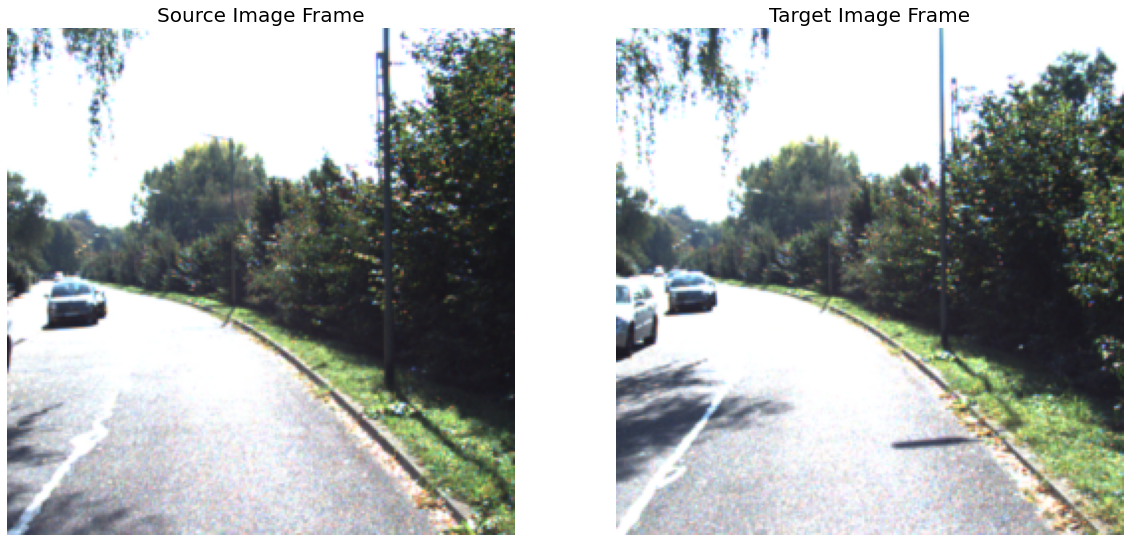

In [5]:
plt.figure(figsize=(20, 10))

ax = plt.subplot(1, 2, 1)
ax.imshow(images[0].permute(1, 2, 0) * 0.5 + 0.5)
ax.set_title('Source Image Frame', fontsize=20)
ax.axis('off')

ax = plt.subplot(1, 2, 2)
ax.imshow(images[1].permute(1, 2, 0) * 0.5 + 0.5)
ax.set_title('Target Image Frame', fontsize=20)
ax.axis('off')

In [6]:
source_camera = PerspectiveCameras(
    R=split_RT(cameras[0]['P'])[0][None],
    T=split_RT(cameras[0]['P'])[1][None],
    K=torch.from_numpy(cameras[0]['K'])[None]
)

target_camera = PerspectiveCameras(
    R=split_RT(cameras[1]['P'])[0][None],
    T=split_RT(cameras[1]['P'])[1][None],
    K=torch.from_numpy(cameras[1]['K'])[None]
)

plot_scene(
    {
        'scene': {
            'source_camera': source_camera,
            'target_camera': target_camera
        }
    },
)

In [7]:
indexes = torch.randperm(len(dataset))

train_indexes = indexes[:-1000]
validation_indexes = indexes[-1000:]

train_dataset = Subset(dataset, train_indexes)
validation_dataset = Subset(dataset, validation_indexes)

train_dataloader = DataLoader(
    train_dataset, batch_size=8, num_workers=2,
    shuffle=True, drop_last=True, pin_memory=True
)
validation_dataloder = DataLoader(
    validation_dataset, batch_size=10, num_workers=2,
    pin_memory=True
)

---

# Models

So, we need to implement `Spatial Feature Predictor`, `Depth Regressor`, `Point Cloud Renderer` and `RefinementNetwork`.

One of the main building blocks in these networks is `ResNetBlock`, but with some modifications:

![image](https://user-images.githubusercontent.com/20357655/145711537-eebb0cb9-8935-4d65-bc4b-559c1e19ba98.png)

So, let's implement it, but without the noise part `Linear + z` (let's omit it, since we do not use the adversarial criterion)

In [8]:
class ResNetBlock(nn.Module):

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        stride: int = 1,
        mode = 'identity'
    ):
        super().__init__()
        
        if mode == 'identity':
          self.mode = nn.Identity()
        elif mode == 'upsample':
          self.mode = nn.Upsample(scale_factor=2)
        else:
          self.mode = nn.AvgPool2d(kernel_size=2)

        self.skip = nn.Sequential(self.mode, nn.Conv2d(in_channels, out_channels, 1))
        self.backbone = nn.Sequential(nn.BatchNorm2d(in_channels), nn.ReLU(), 
                                      self.mode, nn.Conv2d(in_channels, out_channels, 3, 1, 1), 
                                      nn.BatchNorm2d(out_channels), nn.ReLU(), nn.Conv2d(out_channels, out_channels, 3, 1, 1))
    
    def forward(self, input):
        return self.skip(input) + self.backbone(input)

## Spatial Feature Predictor

![image](https://user-images.githubusercontent.com/20357655/145711931-be08e4f9-f383-4942-8b93-f8bdfd3060d2.png)

In [9]:
class SpatialFeatureNetwork(nn.Module):
    
    def __init__(self, in_channels=3, out_channels=64):
        super().__init__()
        self.blocks = nn.Sequential(ResNetBlock(3, 16), ResNetBlock(16, 16), ResNetBlock(16, 16), ResNetBlock(16, 32),
                                    ResNetBlock(32, 32), ResNetBlock(32, 32), ResNetBlock(32, 32), ResNetBlock(32, 64))

    def forward(self, input: torch.Tensor):
        return self.blocks(input)

sf_net = SpatialFeatureNetwork()

## Depth Regressor

![image](https://user-images.githubusercontent.com/20357655/145711785-690008e5-96d0-418f-adf1-1509e399c92e.png)

An `Enc Block` consists of a sequence of Leaky ReLU, convolution (stride 2, padding 1, kernel size 4), and batch normalisation layers.

A `Dec Block` consists of a sequence of ReLU, 2x bilinear upsampling, convolution (stride 1, padding 1, kernel size3), and batch normalisation layers (except for the final layer, which has no batch normalisation layer).

In [19]:
class Unet(nn.Module):

    def __init__(
        self,
        num_filters=32,
        channels_in=3,
        channels_out=3
    ):
        super(Unet, self).__init__()
        self.conv = nn.Conv2d(3, 32, 3, 2, 1)
        self.enc1 = nn.Sequential(nn.LeakyReLU(), nn.Conv2d(32,64,4,2,1), nn.BatchNorm2d(64))
        self.enc2 = nn.Sequential(nn.LeakyReLU(), nn.Conv2d(64,128,4,2,1), nn.BatchNorm2d(128))
        self.enc3 = nn.Sequential(nn.LeakyReLU(), nn.Conv2d(128,256,4,2,1), nn.BatchNorm2d(256))
        self.enc4 = nn.Sequential(nn.LeakyReLU(), nn.Conv2d(256,256,4,2,1), nn.BatchNorm2d(256))
        self.enc5 = nn.Sequential(nn.LeakyReLU(), nn.Conv2d(256,256,4,2,1), nn.BatchNorm2d(256))
        self.enc6 = nn.Sequential(nn.LeakyReLU(), nn.Conv2d(256,256,4,2,1), nn.BatchNorm2d(256))
        self.enc7 = nn.Sequential(nn.LeakyReLU(), nn.Conv2d(256,256,4,2,1), nn.BatchNorm2d(256))

        self.dec1 = nn.Sequential(nn.ReLU(), nn.UpsamplingBilinear2d(scale_factor=2), nn.Conv2d(256, 256, 3, 1, 1), nn.BatchNorm2d(256))
        self.dec2 = nn.Sequential(nn.ReLU(), nn.UpsamplingBilinear2d(scale_factor=2), nn.Conv2d(512, 256, 3, 1, 1), nn.BatchNorm2d(256))
        self.dec3 = nn.Sequential(nn.ReLU(), nn.UpsamplingBilinear2d(scale_factor=2), nn.Conv2d(512, 256, 3, 1, 1), nn.BatchNorm2d(256))
        self.dec4 = nn.Sequential(nn.ReLU(), nn.UpsamplingBilinear2d(scale_factor=2), nn.Conv2d(512, 256, 3, 1, 1), nn.BatchNorm2d(256))
        self.dec5 = nn.Sequential(nn.ReLU(), nn.UpsamplingBilinear2d(scale_factor=2), nn.Conv2d(512, 128, 3, 1, 1), nn.BatchNorm2d(128))
        self.dec6 = nn.Sequential(nn.ReLU(), nn.UpsamplingBilinear2d(scale_factor=2), nn.Conv2d(256, 64, 3, 1, 1), nn.BatchNorm2d(64))
        self.dec7 = nn.Sequential(nn.ReLU(), nn.UpsamplingBilinear2d(scale_factor=2), nn.Conv2d(128, 32, 3, 1, 1), nn.BatchNorm2d(32))
        self.dec8 = nn.Sequential(nn.ReLU(), nn.UpsamplingBilinear2d(scale_factor=2), nn.Conv2d(64, 1, 3, 1, 1))

    def forward(self, input):
      x0 = self.conv(input)
      x1 = self.enc1(x0)
      x2 = self.enc2(x1)
      x3 = self.enc3(x2)
      x4 = self.enc4(x3)
      x5 = self.enc5(x4)
      x6 = self.enc6(x5)
      out = self.enc7(x6)

      out = self.dec1(out)
      out = self.dec2(torch.cat([out, x6], 1))
      out = self.dec3(torch.cat([out, x5], 1))
      out = self.dec4(torch.cat([out, x4], 1))
      out = self.dec5(torch.cat([out, x3], 1))
      out = self.dec6(torch.cat([out, x2], 1))
      out = self.dec7(torch.cat([out, x1], 1))
      out = self.dec8(torch.cat([out, x0], 1))
      return torch.sigmoid(out) # удобнее здесь переводить в отрезок [0, 1]

## Refinement Network

![image](https://user-images.githubusercontent.com/20357655/145711921-45ebf1e5-e852-4c47-8b93-d545f67dc6bf.png)

In [20]:
class RefinementNetwork(nn.Module):
    
    def __init__(self, in_channels=64, out_channels=3):
        super().__init__()
        self.blocks = nn.Sequential(ResNetBlock(in_channels, 32, mode='identity'), ResNetBlock(32, 128, mode='avg'), ResNetBlock(128, 64, mode='avg'),
                                    ResNetBlock(64, 64, mode='identity'), ResNetBlock(64, 64, mode='upsample'), ResNetBlock(64, 64, mode='upsample'),
                                    ResNetBlock(64, 64, mode='identity'), ResNetBlock(64, out_channels, mode='identity'))
    
    def forward(self, input: torch.Tensor):
        return self.blocks(input)

## Auxiliary network

In [22]:
class VGG19(nn.Module):
    def __init__(self, requires_grad=False):
        super().__init__()
        vgg_pretrained_features = torchvision.models.vgg19(
            pretrained=True
        ).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        self.slice5 = torch.nn.Sequential()
        for x in range(2):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(2, 7):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(7, 12):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(12, 21):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        for x in range(21, 30):
            self.slice5.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        # Normalize the image so that it is in the appropriate range
        h_relu1 = self.slice1(X)
        h_relu2 = self.slice2(h_relu1)
        h_relu3 = self.slice3(h_relu2)
        h_relu4 = self.slice4(h_relu3)
        h_relu5 = self.slice5(h_relu4)
        out = [h_relu1, h_relu2, h_relu3, h_relu4, h_relu5]
        return out

---

# Criterions & Metrics

In [23]:
class PerceptualLoss(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # Set to false so that this part of the network is frozen
        self.model = VGG19(requires_grad=False)
        self.criterion = nn.L1Loss()
        self.weights = [1.0 / 32, 1.0 / 16, 1.0 / 8, 1.0 / 4, 1.0]

    def forward(self, pred_img, gt_img):
        gt_fs = self.model(gt_img)
        pred_fs = self.model(pred_img)

        # Collect the losses at multiple layers (need unsqueeze in
        # order to concatenate these together)
        loss = 0
        for i in range(0, len(gt_fs)):
            loss += self.weights[i] * self.criterion(pred_fs[i], gt_fs[i])

        return loss


In [24]:
def psnr(predicted_image, target_image):
    batch_size = predicted_image.size(0)
    mse_err = (
        (predicted_image - target_image)
        .pow(2).sum(dim=1)
        .view(batch_size, -1).mean(dim=1)
    )

    psnr = 10 * (1 / mse_err).log10()
    return psnr.mean()

---

# Point Cloud Renderer

`Differential Rasterization` is a key component of our system. We will use the algorithm already implemented in `pytorch3d`.

![image](https://user-images.githubusercontent.com/20357655/145715968-94abbe1a-8d14-4c20-98c4-61afd9161ada.png)

For more details read (3.2) https://arxiv.org/pdf/1912.08804.pdf

In [25]:
class PointsRasterizerWithBlending(nn.Module):
    """
    Rasterizes a set of points using a differentiable renderer. 
    """

    def __init__(self, radius=1.5, image_size=256, points_per_pixel=8):
        super().__init__()

        self.radius = radius
        self.image_size = image_size
        self.points_per_pixel = points_per_pixel
        
        self.rad_pow = 2
        self.tau = 1.0

    def forward(self, point_cloud, spatial_features):
        batch_size = spatial_features.size(0)

        # Make sure these have been arranged in the same way
        assert point_cloud.size(2) == 3
        assert point_cloud.size(1) == spatial_features.size(2)

        point_cloud[:, :, 1] = -point_cloud[:, :, 1]
        point_cloud[:, :, 0] = -point_cloud[:, :, 0]

        radius = float(self.radius) / float(self.image_size) * 2.0

        point_cloud = Pointclouds(points=point_cloud, features=spatial_features.permute(0, 2, 1))
        points_idx, _, dist = rasterize_points(
            point_cloud, self.image_size, radius, self.points_per_pixel
        )

        dist = dist / pow(radius, self.rad_pow)

        alphas = (
            (1 - dist.clamp(max=1, min=1e-3).pow(0.5))
            .pow(self.tau)
            .permute(0, 3, 1, 2)
        )
    
        transformed_src_alphas = compositing.alpha_composite(
            points_idx.permute(0, 3, 1, 2).long(),
            alphas,
            point_cloud.features_packed().permute(1, 0),
        )

        return transformed_src_alphas

And `PointsManipulator` do the following steps:

    1) Create virtual image place in [normalized coordinate](https://pytorch3d.org/docs/cameras)
    2) Move camera according to `regressed depth`
    3) Rotate points according to target camera paramers
    4) And finally render them with help of `PointsRasterizerWithBlending`

In [26]:
class PointsManipulator(nn.Module):
    EPS = 1e-5

    def __init__(self, image_size):
        super().__init__()
        # Assume that image plane is square

        self.splatter = PointsRasterizerWithBlending(
            radius=1.0,
            image_size=image_size,
            points_per_pixel=128,
        )

        xs = torch.linspace(0, image_size - 1, image_size) / \
            float(image_size - 1) * 2 - 1
        ys = torch.linspace(0, image_size - 1, image_size) / \
            float(image_size - 1) * 2 - 1

        xs = xs.view(1, 1, 1, image_size).repeat(1, 1, image_size, 1)
        ys = ys.view(1, 1, image_size, 1).repeat(1, 1, 1, image_size)

        xyzs = torch.cat(
            (xs, -ys, -torch.ones(xs.size()), torch.ones(xs.size())), 1
        ).view(1, 4, -1)

        self.register_buffer("xyzs", xyzs)

    def project_pts(self, depth, K, Kinv, RT_cam1, RTinv_cam1, RT_cam2, RTinv_cam2):
        # Project the world points into the new view
        projected_coors = self.xyzs * depth
        projected_coors[:, -1, :] = 1

        # Transform into camera coordinate of the first view
        cam1_X = Kinv.bmm(projected_coors)

        # Transform into world coordinates
        RT = RT_cam2.bmm(RTinv_cam1)

        wrld_X = RT.bmm(cam1_X)

        # And intrinsics
        xy_proj = K.bmm(wrld_X)

        # And finally we project to get the final result
        mask = (xy_proj[:, 2:3, :].abs() < self.EPS).detach()

        # Remove invalid zs that cause nans
        zs = xy_proj[:, 2:3, :]
        zs[mask] = self.EPS

        sampler = torch.cat((xy_proj[:, 0:2, :] / -zs, xy_proj[:, 2:3, :]), 1)
        sampler[mask.repeat(1, 3, 1)] = -10
        # Flip the ys
        sampler = sampler * torch.Tensor([1, -1, -1]).unsqueeze(0).unsqueeze(
            2
        ).to(sampler.device)

        return sampler

    def forward_justpts(
        self,
        spatial_features, depth,
        K, K_inv, RT_cam1, RTinv_cam1, RT_cam2, RTinv_cam2
    ):
        # Now project these points into a new view
        batch_size, c, w, h = spatial_features.size()

        if len(depth.size()) > 3:
            # reshape into the right positioning
            depth = depth.view(batch_size, 1, -1)
            spatial_features = spatial_features.view(batch_size, c, -1)

        pointcloud = self.project_pts(
            depth, K, K_inv, RT_cam1, RTinv_cam1, RT_cam2, RTinv_cam2
        )
        pointcloud = pointcloud.permute(0, 2, 1).contiguous()
        result = self.splatter(pointcloud, spatial_features)

        return result

---

# All together

In [27]:
class ViewSynthesisModel(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.spatial_feature_predictor = SpatialFeatureNetwork()
        self.depth_regressor = Unet(channels_in=3, channels_out=1)
        self.point_cloud_renderer = PointsManipulator(image_size=256)
        self.refinement_network = RefinementNetwork()

        # Special constant for KITTI dataset
        self.z_min = 1.0
        self.z_max = 50.0

    def forward(self, source_image, Pinv1, P1, Pinv2, P2, K, Kinv):
        # TODO
        # 1) Predict spatial feature for source image
        # 2) Predict depth for source image (dont forget to renormalize depth with z_min/z_max)
        # 3) Generate new features with `point_cloud_renderer`
        # 4) And finnaly apply `refinement_network` to obtain new image
        # 5) return new image, and depth of source image

        spatial_feature = self.spatial_feature_predictor(source_image)

        depth = self.depth_regressor(source_image) # depth \in [-1,1]
        depth = depth * (model.z_max - model.z_min) + model.z_min # depth \in [z_min, z_max]


        new_features = self.point_cloud_renderer.forward_justpts(spatial_feature, depth, 
                                                                 K, Kinv, P1, Pinv1, P2, Pinv2)
        new_image = self.refinement_network(new_features)

        return new_image, depth



---

# Training

In order for the work to be accepted, you must achieve a quality of ~0.5 (validation loss value) and visualize several samples as in the example

In [28]:
device = torch.device('cuda:0')

model = ViewSynthesisModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
histoty = defaultdict(list)

l1_criterion = nn.L1Loss()
perceptual_criterion = PerceptualLoss().to(device)

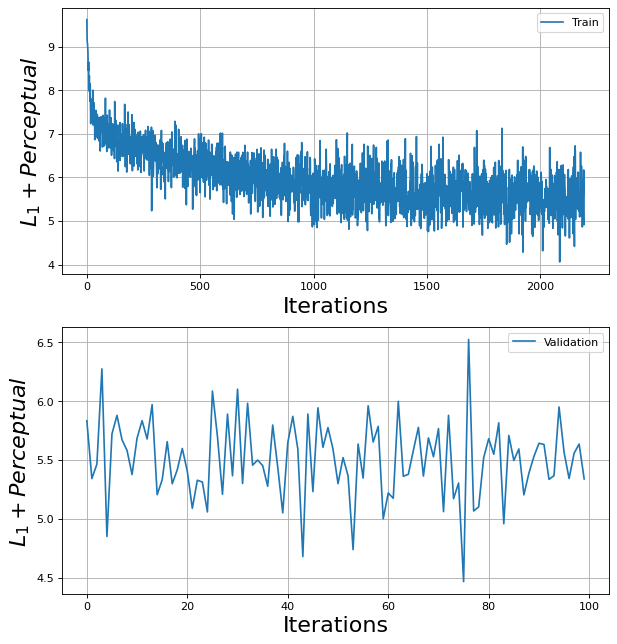

In [29]:
for epoch in range(1):
    for i, batch in tqdm(enumerate(train_dataloader, 2), total=len(train_dataloader)):
        source_image = batch["images"][0].to(device)
        target_image = batch["images"][-1].to(device)

        K = batch["cameras"][0]['K'].to(device)
        Kinv = batch["cameras"][0]['Kinv'].to(device)
        
        Pinv1 = batch["cameras"][0]['Pinv'].to(device)
        P1 = batch["cameras"][0]['P'].to(device)
        Pinv2 = batch["cameras"][1]['Pinv'].to(device)
        P2 = batch["cameras"][1]['P'].to(device)
        
        # TODO
        generated_image, regressed_depth = model(source_image, Pinv1, P1, Pinv2, P2, K, Kinv)

        loss = l1_criterion(generated_image, target_image) \
            + 10 * perceptual_criterion(
            renormalize_image(generated_image),
            renormalize_image(target_image)
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        histoty['train_loss'].append(loss.item())
    
    for i, batch in tqdm(enumerate(validation_dataloder), total=len(validation_dataloder)):
        source_image = batch["images"][0].to(device)
        target_image = batch["images"][-1].to(device)

        K = batch["cameras"][0]['K'].to(device)
        Kinv = batch["cameras"][0]['Kinv'].to(device)
        
        Pinv1 = batch["cameras"][0]['Pinv'].to(device)
        P1 = batch["cameras"][0]['P'].to(device)
        Pinv2 = batch["cameras"][1]['Pinv'].to(device)
        P2 = batch["cameras"][1]['P'].to(device)
        
        with torch.no_grad():
            # TODO
            generated_image, regressed_depth = model(source_image, Pinv1, P1, Pinv2, P2, K, Kinv)

        loss = l1_criterion(generated_image, target_image) \
            + 10 * perceptual_criterion(
            renormalize_image(generated_image),
            renormalize_image(target_image)
        )

        histoty['validation_loss'].append(loss.item())
    
        
    clear_output()
    fig = plt.figure(figsize=(30, 15), dpi=80)
    ax1 = plt.subplot(3, 3, 1)
    ax1.plot(histoty['train_loss'], label='Train')
    ax1.set_xlabel('Iterations', fontsize=20)
    ax1.set_ylabel(r'${L_1} + Perceptual$', fontsize=20)
    ax1.legend()
    ax1.grid()
    
    ax2 = plt.subplot(3, 3, 4)
    ax2.plot(histoty['validation_loss'], label='Validation')
    ax2.set_xlabel('Iterations', fontsize=20)
    ax2.set_ylabel(r'${L_1} + Perceptual$', fontsize=20)
    ax2.legend()
    ax2.grid()

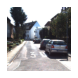

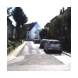

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


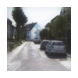

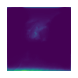

In [32]:
for index, image in zip(
        (2, 3, 5, 6),
        (source_image, target_image, generated_image, regressed_depth)
    ):
        image = renormalize_image(image.detach().cpu()[0]).permute(1, 2, 0)
        if image.shape[2] == 1:
          image = image[...,0]
        ax = plt.subplot(3, 3, index)
        im = ax.imshow(image)
        ax.axis('off')

        plt.show()

# Visualize

Goes along depth and generate new views

In [33]:
RTs = []
for i in torch.linspace(0, 0.5, 40):
    current_RT = torch.eye(4).unsqueeze(0)
    current_RT[:, 2, 3] = i
    RTs.append(current_RT.to(device))
identity_matrx = torch.eye(4).unsqueeze(0).to(device)

In [34]:
random_instance_index = 245
model.eval()

with torch.no_grad():
    images, cameras = validation_dataset[random_instance_index].values()
    # Input values
    input_img = images[0][None].cuda()

    # Camera parameters
    K = torch.from_numpy(cameras[0]["K"])[None].to(device)
    K_inv = torch.from_numpy(cameras[0]["Kinv"])[None].to(device)
    
    spatial_features = model.spatial_feature_predictor(input_img)
    regressed_depth = model.depth_regressor(input_img) * (model.z_max - model.z_min) + model.z_min

    new_images = []
    for current_RT in RTs:
        generated_features = model.point_cloud_renderer.forward_justpts(
            spatial_features,
            regressed_depth,
            K,
            K_inv,
            identity_matrx,
            identity_matrx,
            current_RT,
            None
        )
        generated_image = model.refinement_network(generated_features)
        new_images.append(renormalize_image(generated_image.cpu()).clamp(0, 1).mul(255).to(torch.uint8))

In [35]:
! pip install av --no-binary av

In [36]:
frames = torch.cat(new_images).permute(0, 2, 3, 1)
torchvision.io.write_video('video.mp4', frames, fps=20)

In [39]:
HTML("""
    <video width="256" alt="test" controls>
        <source src="video.mp4" type="video/mp4">
    </video>
""")

# Quality benchmark

![gif](benchmark_video_v1.gif)
![gif](benchmark_video_v2.gif)
![gif](benchmark_video_v3.gif)